# Part 5: Boosted Decision Trees

The `conifer` package was created out of `hls4ml`, providing a similar set of features but specifically targeting inference of Boosted Decision Trees. In this notebook we will train a `GradientBoostingClassifier` with scikit-learn, using the same jet tagging dataset as in the other tutorial notebooks. Then we will convert the model using `conifer`, and run bit-accurate prediction and synthesis as we did with `hls4ml` before.

`conifer` is available from GitHub [here](https://github.com/thesps/conifer), and we have a publication describing the inference implementation and performance in detail [here](https://iopscience.iop.org/article/10.1088/1748-0221/15/05/P05026/pdf).

<img src="https://github.com/thesps/conifer/blob/master/conifer_v1.png?raw=true" width="250" alt="conifer">

In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
import joblib
import conifer
import plotting
import matplotlib.pyplot as plt
import os
os.environ['XILINX_VIVADO']='/home/rrk307/Xilinx/Vivado/2018.3'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
np.random.seed(0)

runtime module could not be imported. Interacting with FPUs will not be possible.


## Load the dataset
Note you need to have gone through `part1_getting_started` to download the data.

In [2]:
os.chdir('/home/rrk307/hls4ml-tutorial')
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

We need to transform the test labels from the one-hot encoded values to labels

In [3]:
le = LabelEncoder().fit(classes)
ohe = OneHotEncoder().fit(le.transform(classes).reshape(-1, 1))
y_train_val = ohe.inverse_transform(y_train_val.astype(int))
y_test = ohe.inverse_transform(y_test)

### Random Forest

#### Testing with rounding operation to thresholds

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Train a BDT
clf = RandomForestClassifier(
    n_estimators=3, max_depth=5, random_state=0).fit( X_train_val, y_train_val.ravel())

pred=clf.predict(X_test)
print('Before rounding to nearest integer')
print ("Classification Report")
print(classification_report(y_test, pred))

for i,dt in enumerate(clf.estimators_):
    print(dt.tree_.threshold)
    
for i,dt in enumerate(clf.estimators_):
    for j,thd in enumerate(dt.tree_.threshold):
        clf.estimators_[i].tree_.threshold[j] = round(j)
        
print('After rounding to nearest integer')
for i,dt in enumerate(clf.estimators_):
    print(dt.tree_.threshold)
    
pred=clf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))

Before rounding to nearest integer
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.68      0.65     33414
           1       0.59      0.66      0.62     32216
           2       0.79      0.78      0.78     33475
           3       0.75      0.75      0.75     33595
           4       0.87      0.69      0.77     33300

    accuracy                           0.71    166000
   macro avg       0.72      0.71      0.72    166000
weighted avg       0.73      0.71      0.72    166000

[ 0.93971717  0.17952049 -0.16502757 -0.80775088 -0.3913448  -2.
 -2.         -0.76053599 -2.         -2.         -0.24935847 -0.42563373
 -2.         -2.         -0.37322378 -2.         -2.          0.07650161
 -0.11636368 -1.22302312 -2.         -2.         -0.16211526 -2.
 -2.         -0.49727909  0.77519202 -2.         -2.          1.13446164
 -2.         -2.          1.11445773  0.35845509  0.85769761  0.04442548
 -2.         -2.          0.0324

/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [5]:
for i,dt in enumerate(clf.estimators_):
    print('Minimum and maximum threshold value is ',min(dt.tree_.threshold), max(dt.tree_.threshold))
    
print('Thresholds of decision trees')
for i,dt in enumerate(clf.estimators_):
    print(dt.tree_.threshold)

Minimum and maximum threshold value is  0.0 62.0
Minimum and maximum threshold value is  0.0 62.0
Minimum and maximum threshold value is  0.0 62.0
Thresholds of decision trees
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]


#### Deeper trees

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
X_train_val, X_val_val, y_train_val, y_val_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

train_acc = {}
val_acc = {}
test_acc = {}
nodes_count = {}
leaves_count = {}
rf_clf = {}
for n_tree in range(3,20,2):
    for depth in range(5,12,2):
        print(f'Testing for {(n_tree,depth)}.')
        rf_clf[(n_tree,depth)] = RandomForestClassifier(n_estimators=n_tree, max_depth=depth)

        y_train_pred = cross_val_predict(rf_clf[(n_tree,depth)], X_train_val, y_train_val.ravel(), cv=2)
        rf_clf[(n_tree,depth)].fit( X_train_val, y_train_val.ravel())

        from sklearn.model_selection import cross_val_score
        train_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_train_val, y_train_val.ravel(), cv=2, scoring="accuracy"))
        val_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_val_val, y_val_val.ravel(), cv=2, scoring="accuracy"))
        test_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_test, y_test, cv=2, scoring="accuracy"))
        nodes_count[(n_tree,depth)] = [tree_i.tree_.node_count for tree_i in rf_clf[(n_tree,depth)].estimators_]
        leaves_count[(n_tree,depth)] = [tree_i.tree_.n_leaves for tree_i in rf_clf[(n_tree,depth)].estimators_]

Testing for (3, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (3, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (3, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (3, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (5, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (5, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (5, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (5, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (7, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (7, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (7, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (7, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (9, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (9, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (9, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (9, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (11, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (11, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (11, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (11, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (13, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (13, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (13, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (13, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (15, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (15, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (15, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (15, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (17, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (17, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (17, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (17, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (19, 5).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (19, 7).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (19, 9).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing for (19, 11).


/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/rrk307/anaconda3/envs/rupesh_python/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


##### Accuracy

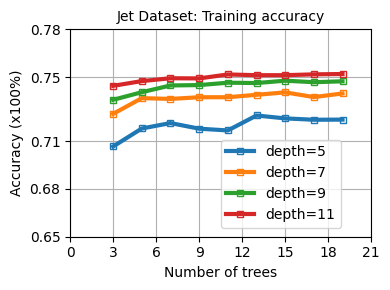

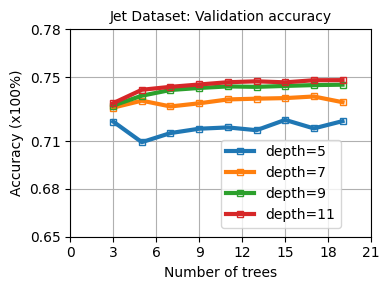

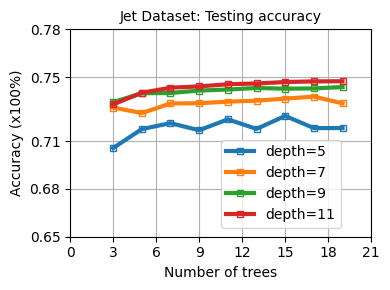

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in train_acc.keys()]):
    plt.plot(np.unique([i[0] for i in train_acc.keys()]), [train_acc[j,depth] for j in np.unique([i[0] for i in train_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))    
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('Jet Dataset: Training accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.68, 0.71, 0.75, 0.78], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_Jet_train.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in val_acc.keys()]):
    plt.plot(np.unique([i[0] for i in val_acc.keys()]), [val_acc[j,depth] for j in np.unique([i[0] for i in val_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('Jet Dataset: Validation accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.68, 0.71, 0.75, 0.78], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_Jet_val.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in test_acc.keys()]):
    plt.plot(np.unique([i[0] for i in test_acc.keys()]), [test_acc[j,depth] for j in np.unique([i[0] for i in test_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('Jet Dataset: Testing accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.68, 0.71, 0.75, 0.78], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_Jet_test.pdf')
plt.show()